In [182]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

In [183]:
data_folder = "C:\\Users\\shyen\\fasanara-digital\\data\\"

In [184]:
%ls $data_folder

 Volume in drive C is Windows
 Volume Serial Number is 467B-0967

 Directory of C:\Users\shyen\fasanara-digital\data

20/10/2022  13:54    <DIR>          .
20/10/2022  13:54    <DIR>          ..
20/10/2022  09:48       740,949,985 binance_book_snapshot_25_2022-09-28_BTCUSDT.csv
20/10/2022  09:48       601,187,861 binance_trades_2022-09-28_BTCUSDT.csv
20/10/2022  09:47     1,799,316,105 binance-futures_book_snapshot_25_2022-09-28_BTCUSDT.csv
20/10/2022  09:47       569,404,075 binance-futures_trades_2022-09-28_BTCUSDT.csv
20/10/2022  09:48     4,229,977,389 okex_book_snapshot_25_2022-09-28_BTC-USDT.csv
20/10/2022  09:47        24,819,925 okex_trades_2022-09-28_BTC-USDT.csv
               6 File(s)  7,965,655,340 bytes
               2 Dir(s)  50,148,761,600 bytes free


In [369]:
df1 = pd.read_csv(data_folder + "binance_book_snapshot_25_2022-09-28_BTCUSDT.csv")
df2 = pd.read_csv(data_folder + "binance_trades_2022-09-28_BTCUSDT.csv")
#df3 = pd.read_csv(data_folder + "binance-futures_book_snapshot_25_2022-09-28_BTCUSDT.csv")
#df4 = pd.read_csv(data_folder + "binance-futures_trades_2022-09-28_BTCUSDT.csv")
#df5 = pd.read_csv(data_folder + "okex_book_snapshot_25_2022-09-28_BTC-USDT.csv")
#df6 = pd.read_csv(data_folder + "okex_trades_2022-09-28_BTC-USDT.csv")

In [370]:
df1 = df1.drop(['exchange', 'symbol', 'local_timestamp'], axis=1)
df2 = df2.filter(items=('timestamp', 'side', 'price', 'amount'))

In [371]:
df2['timestamp_sec'] = df2.timestamp.apply(lambda x: int(str(x)[:10]))
df2['datetime'] = pd.to_datetime(df2['timestamp_sec'], unit = 's')
df2['value'] = df2.price*df2.amount

In [372]:
df1['timestamp_sec'] = df1.timestamp.apply(lambda x: int(str(x)[:10]))
df1['datetime'] = pd.to_datetime(df1['timestamp_sec'], unit = 's')

In [373]:
df1['askbidspread'] = (df1['asks[0].price']-df1['bids[0].price'])/df1['asks[0].price']

In [374]:
df1['best_ask_value'] = df1['asks[0].price']*df1['asks[0].amount']
df1['best_bid_value'] = df1['bids[0].price']*df1['bids[0].amount']

In [375]:
# complete timestamp by seconds
# two seconds less than df2
s = []
for i in range(1664323200+2, 1664409599+1):
    s.append(i)
s = pd.DataFrame(s)
df1_1 = s.rename(columns={0:'timestamp_sec'})
df1_1['datetime'] = pd.to_datetime(df1_1['timestamp_sec'], unit = 's')

In [376]:
a = df1.groupby('datetime')[['best_ask_value', 'best_bid_value']].sum().reset_index()
a['best_ask_amount'] = df1.groupby('datetime')[['asks[0].amount']].sum().reset_index()['asks[0].amount']
a['best_bid_amount'] = df1.groupby('datetime')[['bids[0].amount']].sum().reset_index()['bids[0].amount']
a['VWAP_best_ask'] = a['best_ask_value']/a['best_ask_amount']
a['VWAP_best_bid'] = a['best_bid_value']/a['best_bid_amount']

In [377]:
a['logratio_amount_best_ask_bid'] = np.log(a['best_ask_amount']/a['best_bid_amount'])

In [378]:
df1_1 = df1_1.merge(a, how='left', on='datetime')

In [379]:
t = df1['asks[0].amount']
for i in range(1,25):
    ask = 'asks['+str(i)+'].amount'
    t = t + df1[ask]
df1['ask_total_amount'] = t

t = df1['bids[0].amount']
for i in range(1,25):
    bid = 'bids['+str(i)+'].amount'
    t = t + df1[bid]
df1['bid_total_amount'] = t

In [ ]:
df1_1 = df1_1.merge(df1.groupby('datetime')[['ask_total_amount', 'bid_total_amount']].mean().reset_index(), how='left', on='datetime')

In [427]:
t = df1['asks[0].amount']
for i in range(1,10):
    ask = 'asks['+str(i)+'].amount'
    t = t + df1[ask]
df1['ask_till_10_amount'] = t

t = df1['bids[0].amount']
for i in range(1,10):
    bid = 'bids['+str(i)+'].amount'
    t = t + df1[bid]
df1['bid_till_10_amount'] = t

In [428]:
df1_1 = df1_1.merge(df1.groupby('datetime')[['ask_till_10_amount', 'bid_till_10_amount']].mean().reset_index(), how='left', on='datetime')

In [429]:
df1_1['logratio_amount_till_10_ask_bid'] = np.log(df1_1['ask_till_10_amount']/df1_1['bid_till_10_amount'])

In [397]:
df1_1['logratio_amount_total_ask_bid'] = np.log(df1_1['ask_total_amount']/df1_1['bid_total_amount'])


In [430]:
df1_1.fillna(method='ffill', inplace=True)

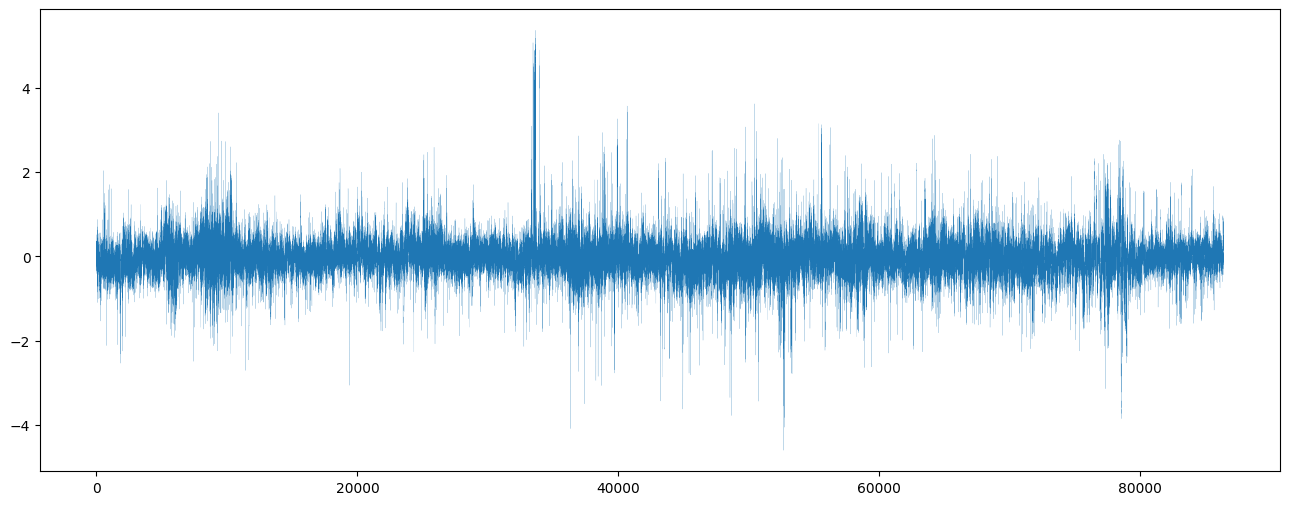

In [425]:
plt.figure(figsize=(16,6))
plt.plot(df1_1['logratio_amount_total_ask_bid'], linewidth=0.1)

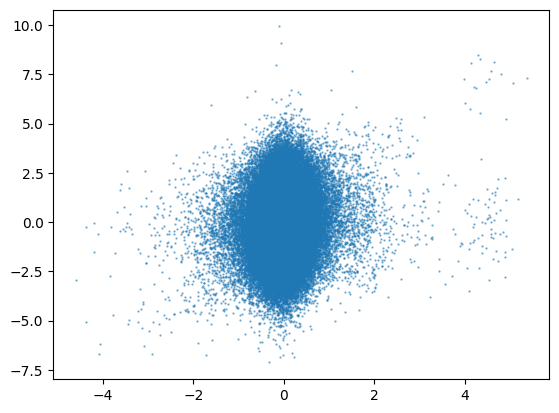

In [406]:
plt.scatter(df1_1['logratio_amount_total_ask_bid'], df1_1['logratio_amount_best_ask_bid'], s=0.5, alpha=0.5)

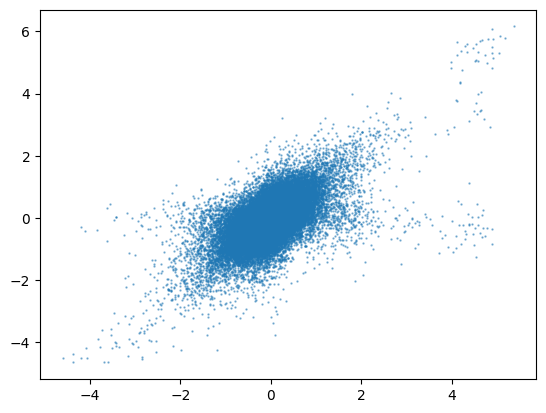

In [432]:
plt.scatter(df1_1['logratio_amount_total_ask_bid'], df1_1['logratio_amount_till_10_ask_bid'], s=0.5, alpha=0.5)

<AxesSubplot: xlabel='logratio_amount_best_ask_bid', ylabel='Count'>

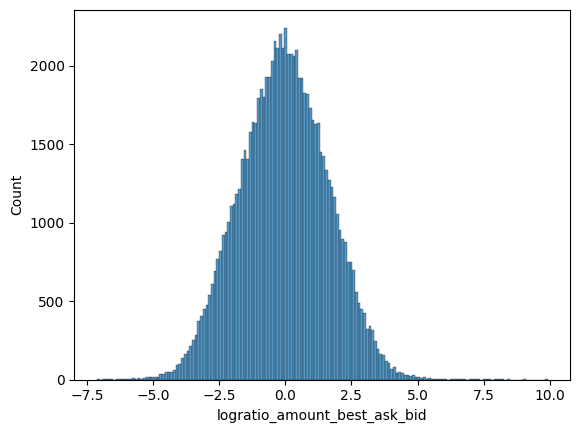

In [396]:
sns.histplot(df1_1['logratio_amount_best_ask_bid'])

<AxesSubplot: xlabel='logratio_amount_total_ask_bid', ylabel='Count'>

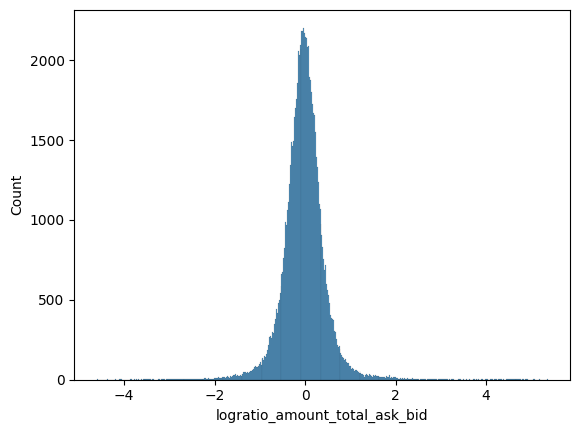

In [399]:
sns.histplot(df1_1['logratio_amount_total_ask_bid'])

In [385]:
df2.head(10)

,timestamp,side,price,amount,timestamp_sec,datetime,value
0,1664323199997000,sell,19078.10,0.00082,1664323199,2022-09-27 23:59:59,15.644042
1,1664323199998000,buy,19079.13,0.00309,1664323199,2022-09-27 23:59:59,58.954512
2,1664323200000000,sell,19078.10,0.00238,1664323200,2022-09-28 00:00:00,45.405878
3,1664323200002000,sell,19078.10,0.00084,1664323200,2022-09-28 00:00:00,16.025604
4,1664323200003000,sell,19078.10,0.00279,1664323200,2022-09-28 00:00:00,53.227899
5,1664323200003000,buy,19079.13,0.00090,1664323200,2022-09-28 00:00:00,17.171217
6,1664323200005000,sell,19078.10,0.00083,1664323200,2022-09-28 00:00:00,15.834823
7,1664323200007000,buy,19079.13,0.00198,1664323200,2022-09-28 00:00:00,37.776677
8,1664323200007000,sell,19078.10,0.00411,1664323200,2022-09-28 00:00:00,78.410991
9,1664323200007000,buy,19079.13,0.00068,1664323200,2022-09-28 00:00:00,12.973808


In [386]:
s = pd.DataFrame(df2.groupby('datetime')['value'].sum() / df2.groupby('datetime')['amount'].sum())
s.rename(columns={0 : 'VWAP'}, inplace=True)
s = s.reset_index()
vwap = s.copy()

In [387]:
vwap

,datetime,VWAP
0,2022-09-27 23:59:59,19078.913990
1,2022-09-28 00:00:00,19083.569006
2,2022-09-28 00:00:01,19085.933959
3,2022-09-28 00:00:02,19084.530721
4,2022-09-28 00:00:03,19084.777468
...,...,...
86375,2022-09-28 23:59:55,19413.488934
86376,2022-09-28 23:59:56,19414.534823
86377,2022-09-28 23:59:57,19413.440806
86378,2022-09-28 23:59:58,19413.277607


In [388]:
# complete timestamp by seconds
s = []
for i in range(1664323200, 1664409599+1):
    s.append(i)
s = pd.DataFrame(s)
df2_1 = s.rename(columns={0:'timestamp_sec'})
df2_1['datetime'] = pd.to_datetime(df2_1['timestamp_sec'], unit = 's')

In [389]:
vol = df2.groupby('datetime').amount.sum()
price = df2.groupby('datetime').price.agg([len,min,max]).reset_index()

In [390]:
# merge tables
df2_1 = df2_1.merge(price, on='datetime', how='left')
df2_1.rename(columns={'len' : 'numTrade', 'min': 'minPx', 'max':'maxPx'}, inplace=True)

df2_1 = df2_1.merge(vwap, on='datetime', how='left')
# fill by previous values
df2_1.fillna(method = 'ffill', inplace=True)

In [391]:
df2['buy'] = df2['side'].apply(lambda x: 1 if x == 'buy' else 0)
df2['buy_amount'] = df2.amount*df2.buy
df2['sell'] = df2['side'].apply(lambda x: 1 if x == 'sell' else 0)
df2['sell_amount'] = df2.amount*df2.sell

In [392]:
# merge tables
a = pd.DataFrame(df2.groupby('datetime').buy_amount.sum()).reset_index()
df2_1 = df2_1.merge(a, on='datetime', how='left')
# merge tables
b = pd.DataFrame(df2.groupby('datetime').sell_amount.sum()).reset_index()
df2_1 = df2_1.merge(b, on='datetime', how='left')

In [685]:
df2_1.fillna(method='ffill', inplace=True)

In [825]:
result = df2_1.copy()
## shift by 60 secs
delay = 15
result.drop(['timestamp_sec'], axis=1)
result['next_VWAP'] = result.VWAP.shift(-delay)
result['log_return'] = np.log(np.array(result.next_VWAP/result.VWAP))

t = df1_1.drop(['best_ask_value', 'best_bid_value', 'timestamp_sec'], axis=1)
result = result.merge(t, how='left', on='datetime').iloc[2:]

# simple moving averages of VWAP
result['SMA300_VWAP'] = result['VWAP'].rolling(300).mean()
result['SMA100_VWAP'] = result['VWAP'].rolling(100).mean()
result['SMA50_VWAP'] = result['VWAP'].rolling(50).mean()

# drop NaN
result = result.iloc[300:]
result = result.iloc[:-delay]

In [826]:
# split into training and test sets
result_test = result.iloc[60060:]
result_train = result.iloc[:60060]

In [827]:
result_train.head(3)

,timestamp_sec,datetime,numTrade,minPx,maxPx,VWAP,buy_amount,sell_amount,next_VWAP,log_return,...,logratio_amount_best_ask_bid,ask_total_amount,bid_total_amount,logratio_amount_total_ask_bid,ask_till_10_amount,bid_till_10_amount,logratio_amount_till_10_ask_bid,SMA300_VWAP,SMA100_VWAP,SMA50_VWAP
302,1664323502,2022-09-28 00:05:02,83.0,19096.43,19098.86,19097.688461,0.98042,0.84092,19096.999306,-0.000036,...,0.330696,5.726715,8.101048,-0.346851,3.591172,4.816675,-0.293605,19085.674625,19091.760709,19092.895847
303,1664323503,2022-09-28 00:05:03,41.0,19096.83,19098.60,19098.308484,2.03179,0.11881,19095.878166,-0.000127,...,-0.790545,6.658650,8.614610,-0.257543,3.294951,5.745261,-0.555984,19085.719728,19091.854374,19093.016937
304,1664323504,2022-09-28 00:05:04,57.0,19097.40,19098.73,19098.189913,0.84930,0.36151,19094.850074,-0.000175,...,0.634969,6.631022,8.651880,-0.266018,2.533227,5.123876,-0.704417,19085.761075,19091.945662,19093.147069


Text(0.5, 1.0, 'logratio_amount_till_10_ask_bid')

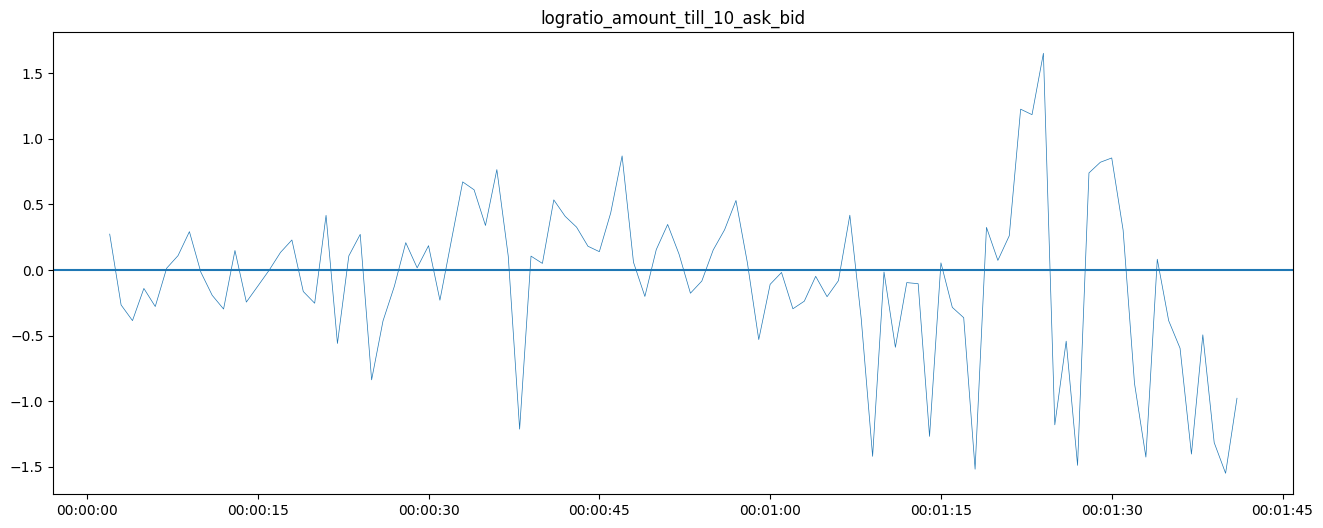

In [794]:
plt.figure(figsize=(16,6))
plt.plot(df1_1.datetime.iloc[0:100], df1_1.logratio_amount_till_10_ask_bid.iloc[0:100], linewidth=0.5)
plt.axhline(y=0)
plt.title("logratio_amount_till_10_ask_bid")

In [795]:
result_train[['logratio_amount_best_ask_bid','logratio_amount_till_10_ask_bid', 'logratio_amount_total_ask_bid', 'VWAP', 'next_VWAP']].corr()

,logratio_amount_best_ask_bid,logratio_amount_till_10_ask_bid,logratio_amount_total_ask_bid,VWAP,next_VWAP
logratio_amount_best_ask_bid,1.000000,0.319802,0.095387,-0.007414,-0.007645
logratio_amount_till_10_ask_bid,0.319802,1.000000,0.623481,-0.030364,-0.031342
logratio_amount_total_ask_bid,0.095387,0.623481,1.000000,-0.074391,-0.075083
VWAP,-0.007414,-0.030364,-0.074391,1.000000,0.999336
next_VWAP,-0.007645,-0.031342,-0.075083,0.999336,1.000000


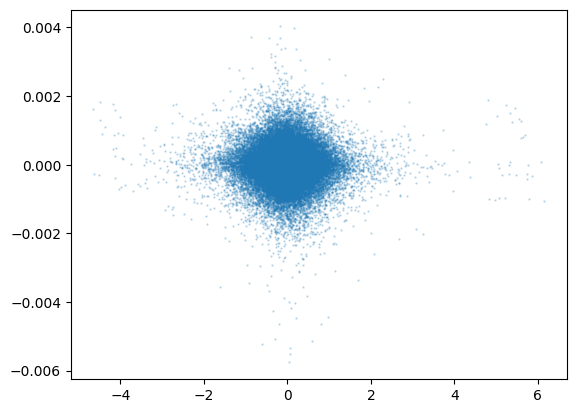

In [824]:
import math
plt.scatter(result_train.logratio_amount_till_10_ask_bid, np.log(np.array(result_train.next_VWAP/result_train.VWAP)), s=0.5, alpha=0.24)

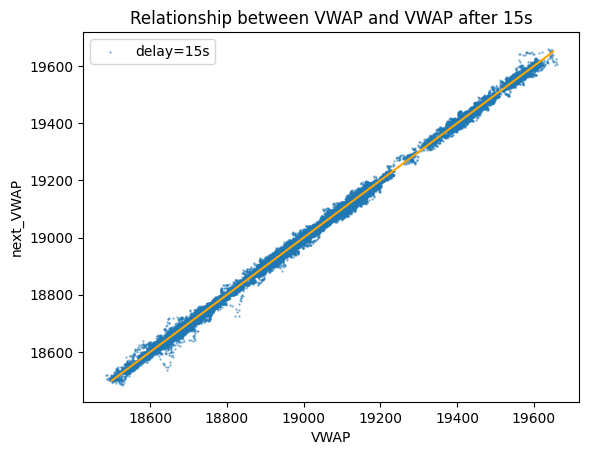

In [828]:
plt.scatter(result_train.VWAP, result_train.next_VWAP, s=0.5, alpha=0.5, label='delay='+str(delay)+'s')
plt.xlabel('VWAP')
plt.ylabel('next_VWAP')
plt.legend()
plt.title('Relationship between VWAP and VWAP after '+ str(delay) + 's')
plt.plot([18500,19650],[18500,19650], c='orange')

In [829]:
X = result_train.drop(['next_VWAP', 'datetime', 'timestamp_sec'], axis=1)
y = result_train.next_VWAP

Text(0.5, 1.0, 'log_return of training data')

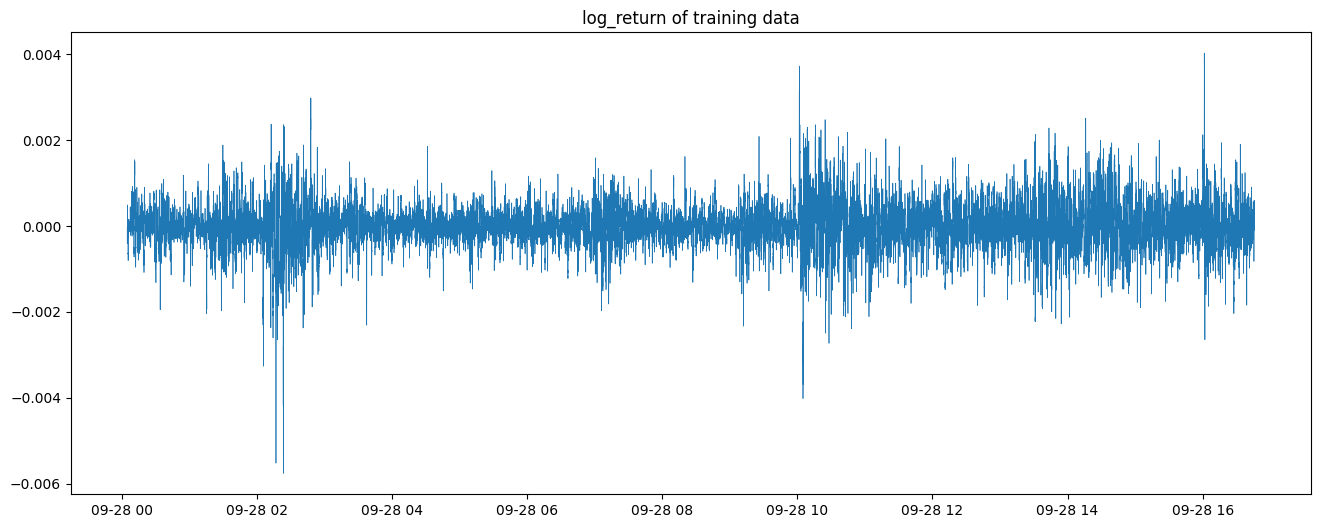

In [839]:
plt.figure(figsize=(16,6))
plt.plot(result_train.datetime, result_train.log_return, linewidth=0.5)
plt.title("log_return of training data")

In [814]:
# simple model with few features

#X_1 = X[['logratio_amount_best_ask_bid','logratio_amount_till_10_ask_bid', 'logratio_amount_total_ask_bid', 'VWAP']]
#X_test = result_test[['logratio_amount_best_ask_bid','logratio_amount_till_10_ask_bid', 'logratio_amount_total_ask_bid', 'VWAP']]
X_1 = X[['logratio_amount_till_10_ask_bid', 'VWAP']]
X_test_1 = result_test[['logratio_amount_till_10_ask_bid', 'VWAP']]
y_test = result_test.next_VWAP
# linear model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

lr = LinearRegression()
lr.fit(X_1, y)
y_pred_lr = lr.predict(X_test_1)

from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred_lr, squared=False)     

9.253706838815678

In [815]:
X_1 = X[['VWAP']]
X_test_1 = result_test[[ 'VWAP']]
y_test = result_test.next_VWAP
# linear model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

lr = LinearRegression()
lr.fit(X_1, y)
y_pred_lr = lr.predict(X_test_1)

from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred_lr, squared=False) 

9.24816923906674

In [807]:
import statsmodels.api as sm

X_1 = sm.add_constant(X_1, prepend=False)

mod = sm.OLS(y, X_1)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              next_VWAP   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 2.260e+07
Date:                Tue, 25 Oct 2022   Prob (F-statistic):               0.00
Time:                        16:03:08   Log-Likelihood:            -2.2144e+05
No. Observations:               60060   AIC:                         4.429e+05
Df Residuals:                   60057   BIC:                         4.429e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
logratio_a

In [811]:
X_test_1 = sm.add_constant(X_test_1, prepend=False)

y_pred_1 = mod.predict(X_test_1)
#????

ValueError: shapes (60060,3) and (26023,3) not aligned: 3 (dim 1) != 26023 (dim 0)

In [800]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0, shuffle=False)

X_test = result_test.drop(['next_VWAP', 'datetime', 'timestamp_sec'], axis=1)
y_test = result_test.next_VWAP

In [680]:
# using previous VWAP as baseline estimate
import math
from sklearn.metrics import mean_squared_error

mean_squared_error(X_test.VWAP, y_test, squared=False)

7.487167584332023

In [681]:
# linear model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

lr = LinearRegression()
lr.fit(X, y)
y_pred_lr = lr.predict(X_test)

from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred_lr, squared=False)
#r2_score(y_test, y_pred_lr)

7.470521688272987

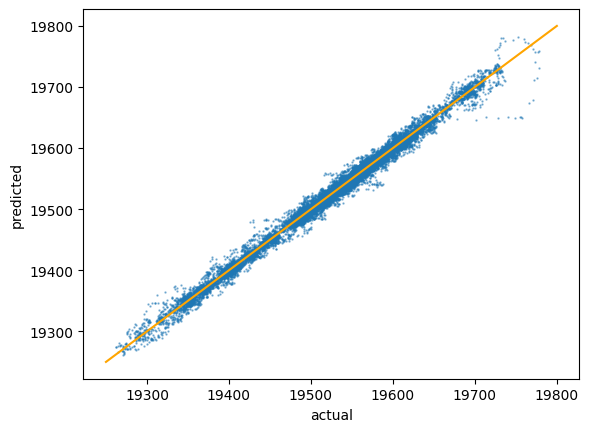

In [682]:
plt.scatter(y_test, y_pred_lr, s=0.5, alpha=0.5)
plt.xlabel('actual')
plt.ylabel('predicted')
plt.plot([19250,19800],[19250,19800], c='orange')

In [666]:
import statsmodels.api as sm

X_1 = sm.add_constant(X, prepend=False)

mod = sm.OLS(y, X_1)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              next_VWAP   R-squared:                       0.948
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                 5.438e+04
Date:                Tue, 25 Oct 2022   Prob (F-statistic):               0.00
Time:                        14:58:37   Log-Likelihood:            -3.3298e+05
No. Observations:               60060   AIC:                         6.660e+05
Df Residuals:                   60039   BIC:                         6.662e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
numTrade  

In [667]:
# XGboost
from xgboost import XGBRegressor

my_model = XGBRegressor(n_estimators=500, learning_rate=0.05, early_stopping_rounds=5, eval_metric = 'rmse')
my_model.fit(X_train, y_train,
             eval_set=[(X_valid, y_valid)], 
             verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=5, enable_categorical=False,
             eval_metric='rmse', gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

# retrieve performance metrics
results = my_model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)
# plot rmse
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Validation')
ax.legend()

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

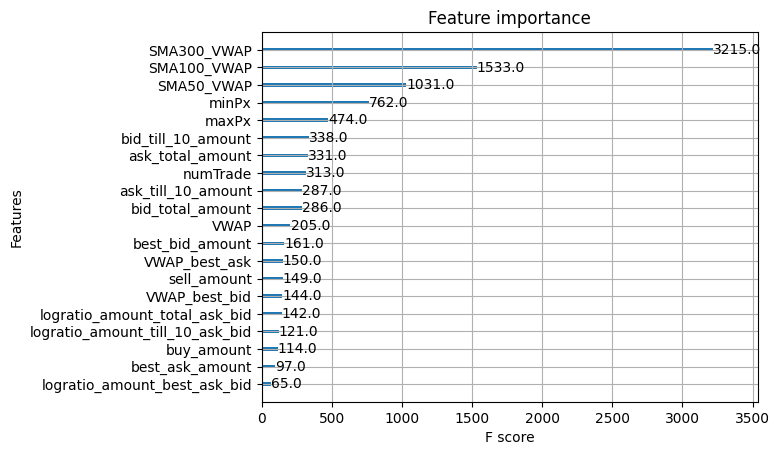

In [668]:
from xgboost import plot_importance
plot_importance(my_model)

In [669]:
X_test = result_test.drop(['next_VWAP', 'datetime', 'timestamp_sec'], axis=1)
y_test = result_test.next_VWAP

In [670]:
y_pred = my_model.predict(X_test)

In [671]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred, squared=False)

402.16858280339807

Text(0, 0.5, 'predicted')

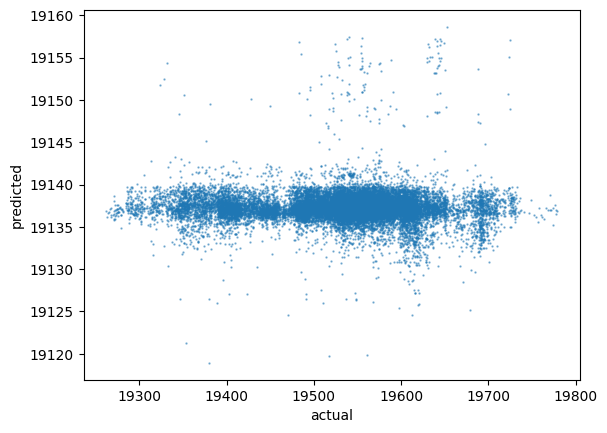

In [672]:
plt.scatter(y_test, y_pred, s=0.5, alpha=0.5)
plt.xlabel('actual')
plt.ylabel('predicted')
#plt.plot([19250,19650],[19250,19650], c='green')

In [641]:
price.reset_index().diff().datetime.value_counts()

0 days 00:00:01    86358
0 days 00:00:02       21
Name: datetime, dtype: int64

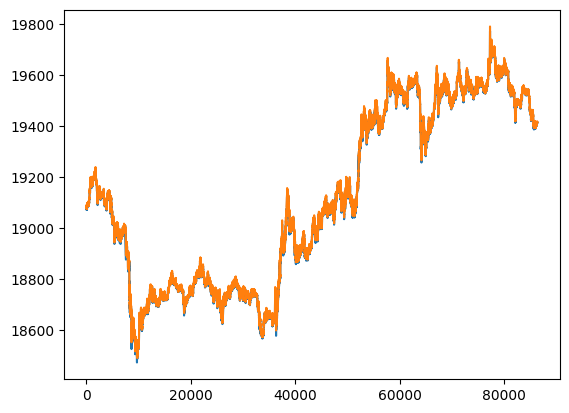

In [642]:
plt.plot(price['min'])
plt.plot(price['max'])